## Fixed Data:

In [3]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [11]:
import json
import requests
import pandas as pd
from fredapi import Fred

API_KEY = '1vGb0FOsg2hEIGrEhpueLCcWd1Y'
FRED_API_KEY = 'b13a905b98b5dfc1f3910d6a0d875ae3'

rootUrl = 'https://api.glassnode.com'

symbolList = ['BTC', 'ETH', 'LTC', 'AAVE', 'ABT', 'AMPL', 'ANT', 'ARMOR', 'BADGER', 'BAL', 'BAND', 'BAT', 'BIX', 'BNT', 'BOND', 'BRD', 'BUSD', 'BZRX', 'CELR', 'CHSB', 'CND', 'COMP', 'CREAM', 'CRO', 'CRV', 'CVC', 'CVP', 'DAI', 'DDX', 'DENT', 'DGX', 'DHT', 'DMG', 'DODO', 'DOUGH', 'DRGN', 'ELF', 'ENG', 'ENJ', 'EURS', 'FET', 'FTT', 'FUN', 'GNO', 'GUSD', 'HEGIC', 'HOT', 'HPT', 'HT', 'HUSD', 'INDEX', 'KCS', 'LAMB', 'LBA', 'LDO', 'LEO', 'LINK', 'LOOM', 'LRC', 'MANA', 'MATIC',
              'MCB', 'MCO', 'MFT', 'MIR', 'MKR', 'MLN', 'MTA', 'MTL', 'MX', 'NDX', 'NEXO', 'NFTX', 'NMR', 'Nsure', 'OCEAN', 'OKB', 'OMG', 'PAY', 'PERP', 'PICKLE', 'PNK', 'PNT', 'POLY', 'POWR', 'PPT', 'QASH', 'QKC', 'QNT', 'RDN', 'REN', 'REP', 'RLC', 'ROOK', 'RPL', 'RSR', 'SAI', 'SAN', 'SNT', 'SNX', 'STAKE', 'STORJ', 'sUSD', 'SUSHI', 'TEL', 'TOP', 'UBT', 'UMA', 'UNI', 'USDC', 'USDK', 'USDP', 'USDT', 'UTK', 'VERI', 'WaBi', 'WAX', 'WBTC', 'WETH', 'wNXM', 'WTC', 'YAM', 'YFI', 'ZRX']

symbolListShort = ['BTC', 'ETH', 'LTC', 'AAVE', 'ABT', 'AMPL', 'ANT', 'ARMOR', 'BADGER', 'BAL']

endPoints = {
    'Price': '/v1/metrics/market/price_usd_close',
    'MarketCap': '/v1/metrics/market/marketcap_usd',
    'TransactionCount': '/v1/metrics/transactions/count',
    'ActiveAddress': '/v1/metrics/addresses/active_count',
}

In [24]:
fred = Fred(api_key=FRED_API_KEY)
Risk_free_rate = fred.get_series('DGS1MO')
Risk_free_rate = Risk_free_rate.to_frame()

Risk_free_rate = Risk_free_rate.reset_index()
Risk_free_rate = Risk_free_rate.rename(columns={'index':'Date', 0:'RiskFree'})

# FF:Add a line of code to change the scale to be consistent with return

In [25]:
Risk_free_rate['RiskFree']= Risk_free_rate['RiskFree']/100
Risk_free_rate

,Date,RiskFree
0,2001-07-31,0.0367
1,2001-08-01,0.0365
2,2001-08-02,0.0365
3,2001-08-03,0.0363
4,2001-08-06,0.0362
...,...,...
5409,2022-04-25,0.0040
5410,2022-04-26,0.0038
5411,2022-04-27,0.0037
5412,2022-04-28,0.0037


In [26]:
Risk_free_rate.isnull().sum()

Date          0
RiskFree    224
dtype: int64

In [27]:
### impute with mean for risk free rate ### will change to linear regression later
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

sim_imp = SimpleImputer(strategy='median')

Risk_free_rate['RiskFree']=sim_imp.fit_transform(Risk_free_rate[['RiskFree']])

In [28]:
Risk_free_rate.isnull().sum()

Date        0
RiskFree    0
dtype: int64

## Get Multiple Attributes for Multiple Coins:

In [29]:
### Define a function to pull data according to input values(coin, feature)
### After running this method, it should return pulled data, and also store it in memory named as "coin_feature"

def PullData(coin, feature):
    print(f"Pulling {coin}'s {feature} data")

    # Assemble full request url and get responses:
    reqUrl = rootUrl + endPoints[feature]
    res = requests.get(reqUrl,
                       params={'a': coin, 'api_key': API_KEY, 'i':'1w'})
    data_raw = pd.read_json(res.text, convert_dates=['t'])

    # Rename column "v" according to features
    data = data_raw.rename(columns={"v" : f"{feature}", 't':'Date'})

    # Turn renamed dataframe into a global variable for future using
    name = f"{coin}_{feature}"
    globals()[name] = data

    # Return a dataframe
    return data

In [30]:
### Get all features(listed in endPoints) of all coins(listed in symbolListShort) 

from functools import reduce

for i in symbolListShort:
    print(f"Start Pulling {i}'s data:")

    # Preparation for merging
    frameName = f"{i}_Frames"
    locals()[frameName] = []

    # Get data
    for j in list(endPoints.keys()):
        locals()[frameName].append(PullData(i, j))

    # Merge to single dataframe
    print('Merging Dataframes...')
    dfName = f"{i}_All"
    # change merge method to outer to ensure not missing any values.
    locals()[dfName] = reduce(lambda  left,right: pd.merge(left,right, on='Date', how='outer'), locals()[frameName]) 
    
    # change merege method to left, to ensure all the records in api stored.
    locals()[dfName] = locals()[dfName].merge(Risk_free_rate,how = 'left',on='Date').sort_values(by=['Date'])

    print(f"{i} data successfully pulled\n")
print('\nALL DATA SUCCESSFULLY PULLED!')

Start Pulling BTC's data:
Pulling BTC's Price data
Pulling BTC's MarketCap data
Pulling BTC's TransactionCount data
Pulling BTC's ActiveAddress data
Merging Dataframes...
BTC data successfully pulled

Start Pulling ETH's data:
Pulling ETH's Price data
Pulling ETH's MarketCap data
Pulling ETH's TransactionCount data
Pulling ETH's ActiveAddress data
Merging Dataframes...
ETH data successfully pulled

Start Pulling LTC's data:
Pulling LTC's Price data
Pulling LTC's MarketCap data
Pulling LTC's TransactionCount data
Pulling LTC's ActiveAddress data
Merging Dataframes...
LTC data successfully pulled

Start Pulling AAVE's data:
Pulling AAVE's Price data
Pulling AAVE's MarketCap data
Pulling AAVE's TransactionCount data
Pulling AAVE's ActiveAddress data
Merging Dataframes...
AAVE data successfully pulled

Start Pulling ABT's data:
Pulling ABT's Price data
Pulling ABT's MarketCap data
Pulling ABT's TransactionCount data
Pulling ABT's ActiveAddress data
Merging Dataframes...
ABT data successful

## <font color='red'> Imputation for NA values for other attributes-- to be resolved

In [ ]:
### impute with mean for risk free rate ###



## Calculate the return - Now only pick lastest 52 records for testing

In [31]:
nainfo = pd.DataFrame(index=LTC_All.columns.values)  #can be improved

for i in symbolListShort:
     
    dfName = f"{i}_All" 

    temp = locals()[dfName][-53:-1].reset_index()
    
    locals()[dfName] = locals()[dfName][-52:].reset_index()   
    
    natemp = locals()[dfName].isnull().sum().to_frame(name= i)
    
    #nainfo pick all the na values
    nainfo = nainfo.join(natemp)  #can be removed, just for data checking purpose
    
    
    locals()[dfName]['Return'] = (locals()[dfName]['Price'] - temp['Price'])/temp['Price']
    


In [32]:
AAVE_All.head()

,index,Date,Price,MarketCap,TransactionCount,ActiveAddress,RiskFree,Return
0,31,2021-05-03,459.310213,5.735887e+09,0,9738,0.0002,-0.049263
1,32,2021-05-10,525.296787,6.648981e+09,0,10036,0.0002,0.143665
2,33,2021-05-17,296.307038,3.779533e+09,0,12152,0.0000,-0.435925
3,34,2021-05-24,324.282384,4.141262e+09,0,11055,0.0001,0.094413
4,35,2021-05-31,365.167460,4.669538e+09,0,7849,0.0042,0.126079


In [33]:
AAVE_All.isnull().sum()

index               0
Date                0
Price               0
MarketCap           0
TransactionCount    0
ActiveAddress       0
RiskFree            0
Return              0
dtype: int64

## Create two sample groups: Full Sample vs Large Cap sample(maket cap > 1m and top 100)
There are two groups of smaple: LaregeCapSample vs Full sample
<br>LargeCapSample : MaketCap > 1m and Capitalization ranked at top 100

In [34]:
## find market portfolio

markdf = pd.DataFrame(columns = LTC_All.columns.values)  # can be improved
fullsample = pd.DataFrame(columns = LTC_All.columns.values)
markdf['Asset'] = ''
fullsample['Asset'] = ''

## step 1: pick all maket cap > 10000
for i in symbolListShort:
     
    dfName = f"{i}_All" 
    
    ## find all date with MarketCap greater than 10000
    mkttemp = locals()[dfName].query("MarketCap > 1000000")
    mkttemp['Asset'] = i
    markdf = markdf.append(mkttemp)
        
    fulltemp = locals()[dfName].query("MarketCap > 0.001")
    fulltemp['Asset'] = i    
    fullsample = fullsample.append(fulltemp)

## sort all the market cap and pick top 100
largeCapSample = markdf.groupby(['Date']).apply(lambda x: x.nlargest(100,['MarketCap'])).reset_index(drop=True)



In [201]:
fullsample.head()

,index,Date,Price,MarketCap,TransactionCount,ActiveAddress,RiskFree,Return,Asset
0,563,2021-04-26,56613.202648,1.058532e+12,1861992.0,5778871,0.0002,0.154432,BTC
1,564,2021-05-03,58218.566077,1.088991e+12,2038316.0,6622607,0.0002,0.028357,BTC
2,565,2021-05-10,46406.331544,8.683518e+11,1908851.0,6062366,0.0002,-0.202895,BTC
3,566,2021-05-17,34888.678313,6.530094e+11,1607054.0,4960283,0.0000,-0.248191,BTC
4,567,2021-05-24,35639.981455,6.672647e+11,1508758.0,4981835,0.0001,0.021534,BTC


In [202]:
largeCapSample.head()

,index,Date,Price,MarketCap,TransactionCount,ActiveAddress,RiskFree,Return,Asset
0,563,2021-04-26,56613.202648,1.058532e+12,1861992.0,5778871,0.0002,0.154432,BTC
1,299,2021-04-26,2952.509999,3.416486e+11,9864476.0,1185768,0.0002,0.276095,ETH
2,415,2021-04-26,269.060433,1.817989e+10,777669.0,1261380,0.0002,0.201887,LTC
3,30,2021-04-26,483.109487,6.033093e+09,0.0,4294,0.0002,0.393008,AAVE
4,44,2021-04-26,61.357531,4.260563e+08,0.0,1380,0.0002,0.282477,BAL


## Calculate MKT for each week

In [35]:
## markdf is a big dataframe include all crypto currencies makcap greater than 1000000
marketport = largeCapSample.groupby('Date')['MarketCap'].sum().reset_index(name='TotalMarketCap')

marketInd = markdf.copy()
marketInd['weights'] = marketInd['Return'] * marketInd['MarketCap']
recomp = marketInd.groupby('Date')['weights'].sum().reset_index(name='TotalMarketReturn')
marketport['MarketIndexReturn'] = recomp['TotalMarketReturn']/ marketport['TotalMarketCap']

In [36]:
marketport = marketport.merge(Risk_free_rate, on='Date')
marketport['MKT'] = marketport['MarketIndexReturn'] - marketport['RiskFree']
MKT_f = marketport[['Date','MKT']]

In [37]:
MKT_f.head()

,Date,MKT
0,2021-05-03,0.122218
1,2021-05-10,-0.165735
2,2021-05-17,-0.295232
3,2021-05-24,0.054651
4,2021-05-31,0.042116


In [38]:
fullsample.head()

,index,Date,Price,MarketCap,TransactionCount,ActiveAddress,RiskFree,Return,Asset
0,564,2021-05-03,58218.566077,1.088991e+12,2038316.0,6622607,0.0002,0.028357,BTC
1,565,2021-05-10,46406.331544,8.683518e+11,1908851.0,6062366,0.0002,-0.202895,BTC
2,566,2021-05-17,34888.678313,6.530094e+11,1607054.0,4960283,0.0000,-0.248191,BTC
3,567,2021-05-24,35639.981455,6.672647e+11,1508758.0,4981835,0.0001,0.021534,BTC
4,568,2021-05-31,35797.422390,6.704378e+11,1582789.0,4893673,0.0042,0.004418,BTC


## Calculate Size - currently use full sample

In [39]:
makcapAll = fullsample.loc[:,['Date', 'MarketCap', 'Asset']].pivot(index="Asset", 
                                                                   columns=["Date"], values='MarketCap')
datestamp = makcapAll.columns.tolist()

In [40]:
# get the average value for the bottom 20 percentile (smallcap) and top 20 percentile(largecap)
datestamp = makcapAll.columns.tolist()
smallcap = {}
largecap = {}
for i in datestamp:
    smallcap[i] = makcapAll[i].sort_values().head(round(0.2*len(makcapAll))).mean()
    largecap[i] = makcapAll[i].sort_values().tail(round(0.2*len(makcapAll))).mean()

In [46]:
smb_f = pd.DataFrame()
smallcapdf = pd.DataFrame(list(smallcap.items()), columns=['Date','SMB-Small']).sort_values('Date')
smb_l = pd.DataFrame(list(largecap.items()), columns=['Date','SMB-Large']).sort_values('Date')
smb_l['SMB'] = smb_l['SMB-Large'] - smallcapdf['SMB-Small']
smb_f =smb_l[['Date','SMB']]
smb_f.head()

,Date,SMB
0,2021-05-03,7.721583e+11
1,2021-05-10,6.417464e+11
2,2021-05-17,4.492639e+11
3,2021-05-24,4.722516e+11
4,2021-05-31,4.926346e+11


## Linear Regression Model

In [47]:
ltc_reg = LTC_All[['Date','RiskFree','Return']]
mkt_smb = MKT_f.merge(smb_f, on = 'Date', how = 'outer')
ltc_reg = ltc_reg.merge(mkt_smb, on = 'Date', how = 'outer')

In [49]:
ltc_reg['ExcessReturn']=ltc_reg['Return']-ltc_reg['RiskFree']
ltc_reg.head(5)

,Date,RiskFree,Return,MKT,SMB,ExcessReturn
0,2021-05-03,0.0002,0.433524,0.122218,7.721583e+11,0.433324
1,2021-05-10,0.0002,-0.231293,-0.165735,6.417464e+11,-0.231493
2,2021-05-17,0.0000,-0.513065,-0.295232,4.492639e+11,-0.513065
3,2021-05-24,0.0001,0.183915,0.054651,4.722516e+11,0.183815
4,2021-05-31,0.0042,0.032219,0.042116,4.926346e+11,0.028019


In [53]:
target = "ExcessReturn"
feature1 = ['MKT']
feature2 = ['SMB']
features =['MKT', 'SMB']

# features.remove(target)
# features.remove("Date")
y = ltc_reg[target].copy()
x1 = ltc_reg [feature1].copy()
x2 = ltc_reg [feature2].copy()
x3 = ltc_reg [features].copy()


In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model1 = LinearRegression()
model2 = LinearRegression()
model3 = LinearRegression()

In [59]:
model1.fit(x1, y)
model2.fit(x2, y)
model3.fit(x3, y)

LinearRegression()

In [60]:
y1 = model1.predict(x1)
y2 = model2.predict(x2)
y3 = model3.predict(x3)

In [71]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def myPlot(factor, excessreturn, model):
    plt.scatter(factor, excessreturn, alpha=0.3)
    x = np.linspace(0, factor.max())
    y = model.predict(x.reshape(-1,1))
    plt.plot(x, y, color='r')
    plt.xlabel('factor')
    plt.ylabel('Excess Return')
    plt.title('Linear regression result for excess return and ONE factor')
    plt.show()

## Fator MKT vs Excess return

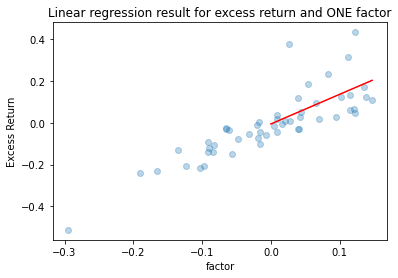

In [72]:
myPlot(ltc_reg.MKT, ltc_reg.ExcessReturn, model1)

In [79]:
### get the alpha with MKT factor only
print('alpha for LTC with MKT is:', model1.intercept_)

alpha for LTC with MKT is: -0.005726423059881254


In [70]:
### measure the performance of MKT Factor
print('MAS for MKT is {: .2e}'.format(mean_absolute_error(y, y1)))
print('MSE for MKT is {: .2e}'.format(mean_squared_error(y, y1)))
print('R2_score for MKT is {: .2f}'.format(r2_score(y, y1)))


MAS for MKT is  5.97e-02
MSE for MKT is  7.38e-03
R2_score for MKT is  0.70


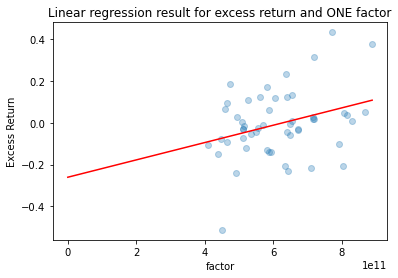

In [73]:
myPlot(ltc_reg.SMB, ltc_reg.ExcessReturn, model2)

In [75]:
print('MAS for SMB is {: .2e}'.format(mean_absolute_error(y, y2)))
print('MSE for SMB is {: .2e}'.format(mean_squared_error(y, y2)))
print('R2_score for SMB is {: .2f}'.format(r2_score(y, y2)))

MAS for SMB is  1.10e-01
MSE for SMB is  2.25e-02
R2_score for SMB is  0.10


In [78]:
### get the alpha with Size factor only
print('alpha for LTC with SMB is:', model2.intercept_)

alpha for LTC with SMB is: -0.2608301748776224


In [76]:
print('MAS for MKT combined with SMB is {: .2e}'.format(mean_absolute_error(y, y3)))
print('MSE for MKT combined with SMB is {: .2e}'.format(mean_squared_error(y, y3)))
print('R2_score for MKT combined with SMB is {: .2f}'.format(r2_score(y, y3)))

MAS for MKT combined with SMB is  6.08e-02
MSE for MKT combined with SMB is  6.98e-03
R2_score for MKT combined with SMB is  0.72


In [77]:
print('alpha for LTC with combination for MKT and SMB is:', model3.intercept_)

alpha for LTC with combination for MKT and SMB is: -0.11001898357492891


## <font color='green'>Testing purpose : try to find the first date with available price

In [89]:
df = pd.DataFrame(columns = LTC_All.columns.values)
df['Asset'] = ''

for i in symbolList:
    
 
    dfName = f"{i}_All" 
    test=pd.DataFrame
    df1 = locals()[dfName][locals()[dfName].Price.notnull()].iloc[0]
    
    df1['Asset'] = i
    df=df.append(df1, ignore_index=True)

    

In [90]:
df.to_csv("firstavailable_price.csv")

In [108]:
new = df.sort_values(by=['Date'])

In [78]:
LTC_All.Price.loc[~LTC_All.Price.isnull()]

0        3.149100
1        3.150000
2        2.830000
3        2.348333
4        2.150000
          ...    
462    129.241438
463    128.926292
464    111.343007
465    109.018201
466    104.648982
Name: Price, Length: 467, dtype: float64